In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Code for disable toggle scrolling
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [2]:
#### Reading the text file into 'lines' variable

with open("movieReviews1000.txt") as file:
    lines = [line.rstrip() for line in file]

#### Isolating the labels

labels = []
for line in lines:
    l = line[-1]
    labels.append(int(l))

#### Storing only the sentences and removing the labels at the end

sentences = []
for line in lines:
    tmp = str(line[-1])
    line = line.replace(tmp,'')
    sentences.append(line.rstrip())

sentences = np.array(sentences)

vectorizer = TfidfVectorizer(stop_words='english')  # Removing the english stop words for a better predictor
X = vectorizer.fit_transform(sentences)

df = pd.DataFrame(X.toarray())

In [3]:
# Splitting dataset into train and test sets
# Using a 0.2 split as the train data was too little to train on while test data was quite large

X_train, X_test, y_train, y_test = train_test_split(df,labels, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test=np.array(y_test)

In [4]:
# Applying scaling on the training data followed by PCA

scaling = StandardScaler()
scaling.fit(X_train)
X_scaled = scaling.transform(X_train)
principal = PCA(n_components = 30)
principal.fit(X_scaled)
X = principal.transform(X_scaled)

In [5]:
# Splitting train set further into train and val sets

X_train, X_val, y_train, y_val = train_test_split(pd.DataFrame(X),y_train, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

## Helper functions

In [6]:
def sigmoid(z):
    ans = 1/(1+np.exp(-z))
    return ans

def h(w,b,x):  # Hypothesis function
    z = np.dot(x,w.T) + b
    return sigmoid(z)

def loss(x,y,w,b,lmbda):
    ZZ = len(y)
    J0 = np.dot(np.log10(h(w,b,x)+1e-8),y)  # Adding a small value in the cost as without the same, the code was giving 0 divide errors
    my = 1- y
    J1 = np.dot(np.log10(1-h(w,b,x)+1e-8),my)
    reg_loss = lmbda*np.matmul(w,w.T)
    J = -((J1 + J0 + (reg_loss/2)))/ZZ
    return J

def update(x,y,w,b,lr,lmbda):
    ZZ = len(y)
    arg = h(w,b,x) - y
    batch_avg = np.matmul(x.T,arg)/(ZZ)
    reg_update = (lmbda*w)/ZZ
    wn = w - lr*(batch_avg+reg_update)
    bn = b - lr*(np.sum(arg))/ZZ
    return wn,bn

def predict(x,w,b):
    z = np.dot(x,w.T) + b
    lis = []
    for i in sigmoid(z):
        if i>0.5:       # This was based on a comparitive analysis by turning the inequality sign. Current set-up gave better accuracy.
            lis.append(1)
        else:
            lis.append(0)
    return np.array(lis)

In [126]:
df = pd.DataFrame(columns = ['Lambda', 'Batch Size', 'Learning Rate', 'Test Accuracy']) ## Stores the accuracy on test set

In [127]:
Xt = scaling.transform(X_test)

Xt = principal.transform(Xt)

def main(batch,lr,lmbda,df):
    d = X_train.shape[0]
    seg = int(d//batch)
    trial = X_train.reshape(batch,seg,30)
    yt = y_train.reshape(batch,seg)
    
    w = np.zeros(30)
    b = np.zeros(1)
    train_loss_list = []
    val_loss_list = []
    epochs = 20

    for k in range(epochs):
        for i in range(trial.shape[0]):
            loss_val = loss(trial[i],yt[i],w,b,lmbda)
            w,b = update(trial[i],yt[i],w,b,lr,lmbda)
        train_loss_list.append(loss_val)
        val_loss = loss(X_val,y_val,w,b,lmbda)
        val_loss_list.append(val_loss)
        if (lmbda==0):
            print("Epoch:",k+1,"--> Train Loss =",loss_val,"\t--> Val Loss =",val_loss)
        w,b = update(X_val,y_val,w,b,lr,lmbda)  # Using validated batch to update parameters

    print("\nTRAIN ACCURACY = ",np.sum(predict(X_train,w,b)==y_train)/len(y_train)*100, "%")
    test_acc = (np.sum(predict(Xt,w,b)==y_test)/len(y_test)*100)
    plt.title("LOSS PLOT-> "+" B: "+str(batch)+" LR: "+str(lr)+" Lambda: "+str(lmbda))
    plt.plot(train_loss_list, label='Train Loss')

    print("VAL ACCURACY = ",np.sum(predict(X_val,w,b)==y_val)/len(y_val)*100, "%")
    plt.plot(val_loss_list, label='Val Loss')
    
    plt.xlabel("# Epochs")
    plt.ylabel("Loss Value")
    plt.legend()
    print("TEST ACCURACY = ",test_acc, "%")
    plt.show()
    
    df = df.append({'Lambda':lmbda,'Batch Size':batch, 'Learning Rate': lr, 'Test Accuracy':test_acc},ignore_index = True)
    
    return df


# Running the main loop

## Lambda = 0 represents no regularization and is for Q5c
## Other cases are for Q5d

BATCH SIZE =  32 	LR =  0.001 	LAMBDA =  0

Epoch: 1 --> Train Loss = 0.30159255540682695 	--> Val Loss = 0.30026601662998775
Epoch: 2 --> Train Loss = 0.29969219531162616 	--> Val Loss = 0.2993466404326754
Epoch: 3 --> Train Loss = 0.298139072865568 	--> Val Loss = 0.2985177256499443
Epoch: 4 --> Train Loss = 0.29685991166787773 	--> Val Loss = 0.2977643462752737
Epoch: 5 --> Train Loss = 0.2957958364958044 	--> Val Loss = 0.297074777071275
Epoch: 6 --> Train Loss = 0.2949006906073442 	--> Val Loss = 0.29643979376898316
Epoch: 7 --> Train Loss = 0.2941387170082087 	--> Val Loss = 0.2958520580682145
Epoch: 8 --> Train Loss = 0.29348233521669637 	--> Val Loss = 0.2953056501477672
Epoch: 9 --> Train Loss = 0.2929102633892227 	--> Val Loss = 0.294795725589872
Epoch: 10 --> Train Loss = 0.292406024992031 	--> Val Loss = 0.2943182652602931
Epoch: 11 --> Train Loss = 0.29195679804823343 	--> Val Loss = 0.2938698922067204
Epoch: 12 --> Train Loss = 0.29155254262675057 	--> Val Loss = 0.293447

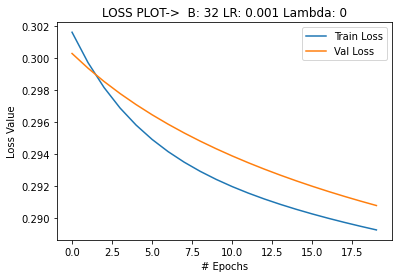

BATCH SIZE =  32 	LR =  0.01 	LAMBDA =  0

Epoch: 1 --> Train Loss = 0.3092583368959263 	--> Val Loss = 0.29499612908077477
Epoch: 2 --> Train Loss = 0.29264433918708466 	--> Val Loss = 0.2912374975006894
Epoch: 3 --> Train Loss = 0.2904328314880901 	--> Val Loss = 0.28881550897737246
Epoch: 4 --> Train Loss = 0.28857430483269997 	--> Val Loss = 0.28711519486955756
Epoch: 5 --> Train Loss = 0.28696044154198097 	--> Val Loss = 0.28585171230453704
Epoch: 6 --> Train Loss = 0.2855437839987774 	--> Val Loss = 0.28486990847804305
Epoch: 7 --> Train Loss = 0.2842915811526957 	--> Val Loss = 0.2840786307091613
Epoch: 8 --> Train Loss = 0.2831795790235413 	--> Val Loss = 0.2834215626014
Epoch: 9 --> Train Loss = 0.2821890587095967 	--> Val Loss = 0.28286241511682886
Epoch: 10 --> Train Loss = 0.28130495210753953 	--> Val Loss = 0.28237693148483417
Epoch: 11 --> Train Loss = 0.2805146895573888 	--> Val Loss = 0.2819483705394555
Epoch: 12 --> Train Loss = 0.27980751518428454 	--> Val Loss = 0.28

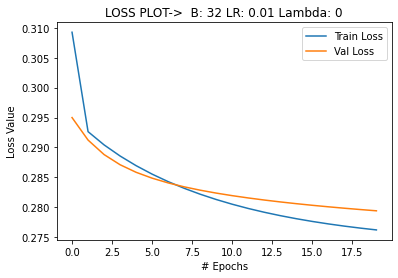

BATCH SIZE =  32 	LR =  0.1 	LAMBDA =  0

Epoch: 1 --> Train Loss = 0.452172186584863 	--> Val Loss = 0.2972001106794061
Epoch: 2 --> Train Loss = 0.2963499885614104 	--> Val Loss = 0.2836555709159512
Epoch: 3 --> Train Loss = 0.3058753647444881 	--> Val Loss = 0.28236476777315384
Epoch: 4 --> Train Loss = 0.2695699774857989 	--> Val Loss = 0.27995285763843264
Epoch: 5 --> Train Loss = 0.31418585351436834 	--> Val Loss = 0.2771353090610278
Epoch: 6 --> Train Loss = 0.2766540942451171 	--> Val Loss = 0.27705429669386633
Epoch: 7 --> Train Loss = 0.29313227134689596 	--> Val Loss = 0.278847838771804
Epoch: 8 --> Train Loss = 0.29651463563871616 	--> Val Loss = 0.274620965277161
Epoch: 9 --> Train Loss = 0.28895778900913216 	--> Val Loss = 0.27390203267594765
Epoch: 10 --> Train Loss = 0.3108570770940013 	--> Val Loss = 0.2759005877708606
Epoch: 11 --> Train Loss = 0.2876157224832997 	--> Val Loss = 0.2737480969056215
Epoch: 12 --> Train Loss = 0.2674609087516659 	--> Val Loss = 0.2771188

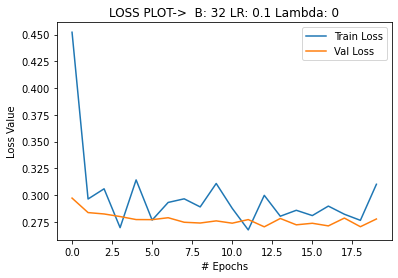

BATCH SIZE =  64 	LR =  0.001 	LAMBDA =  0

Epoch: 1 --> Train Loss = 0.3015985978540209 	--> Val Loss = 0.2995413041129991
Epoch: 2 --> Train Loss = 0.30138148812773186 	--> Val Loss = 0.2981409738979951
Epoch: 3 --> Train Loss = 0.30118540052040577 	--> Val Loss = 0.29697121863416887
Epoch: 4 --> Train Loss = 0.30096197019232473 	--> Val Loss = 0.29596394538781934
Epoch: 5 --> Train Loss = 0.300696787753587 	--> Val Loss = 0.295078557726223
Epoch: 6 --> Train Loss = 0.3003884922072701 	--> Val Loss = 0.294288971273977
Epoch: 7 --> Train Loss = 0.30004063081398485 	--> Val Loss = 0.29357730758925865
Epoch: 8 --> Train Loss = 0.29965836129751444 	--> Val Loss = 0.2929306403532383
Epoch: 9 --> Train Loss = 0.2992470842714554 	--> Val Loss = 0.29233921408295677
Epoch: 10 --> Train Loss = 0.2988118878476 	--> Val Loss = 0.29179541259110364
Epoch: 11 --> Train Loss = 0.2983573461606595 	--> Val Loss = 0.29129312957515213
Epoch: 12 --> Train Loss = 0.2978874739632168 	--> Val Loss = 0.29082

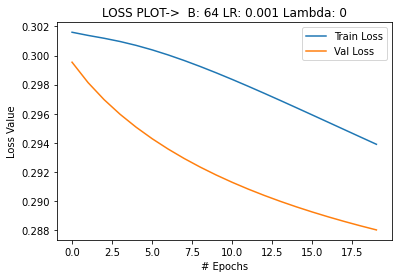

BATCH SIZE =  64 	LR =  0.01 	LAMBDA =  0

Epoch: 1 --> Train Loss = 0.32556791859924894 	--> Val Loss = 0.2917828609979081
Epoch: 2 --> Train Loss = 0.3087335457636925 	--> Val Loss = 0.28791940454420045
Epoch: 3 --> Train Loss = 0.29875888499689085 	--> Val Loss = 0.28547583830440654
Epoch: 4 --> Train Loss = 0.29108568628086323 	--> Val Loss = 0.28392302683249515
Epoch: 5 --> Train Loss = 0.28570322055230185 	--> Val Loss = 0.2828055484840132
Epoch: 6 --> Train Loss = 0.28141618732746926 	--> Val Loss = 0.28193214655800725
Epoch: 7 --> Train Loss = 0.2780875562086778 	--> Val Loss = 0.2812279182628584
Epoch: 8 --> Train Loss = 0.27540587455245824 	--> Val Loss = 0.28063271306993154
Epoch: 9 --> Train Loss = 0.2732258045679864 	--> Val Loss = 0.28011929006639075
Epoch: 10 --> Train Loss = 0.2714243483671542 	--> Val Loss = 0.2796678183979148
Epoch: 11 --> Train Loss = 0.26991869208876434 	--> Val Loss = 0.2792659252287682
Epoch: 12 --> Train Loss = 0.2686459581673731 	--> Val Loss = 

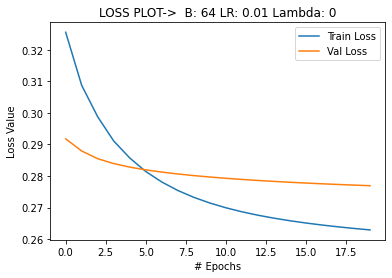

BATCH SIZE =  64 	LR =  0.1 	LAMBDA =  0

Epoch: 1 --> Train Loss = 0.6965754845190658 	--> Val Loss = 0.34245176475422995
Epoch: 2 --> Train Loss = 0.3481744668329924 	--> Val Loss = 0.3108271316673573
Epoch: 3 --> Train Loss = 0.5521357106081968 	--> Val Loss = 0.325357128811777
Epoch: 4 --> Train Loss = 0.25229543361562967 	--> Val Loss = 0.28641743286166965
Epoch: 5 --> Train Loss = 0.679917219794307 	--> Val Loss = 0.3038812907873442
Epoch: 6 --> Train Loss = 0.24179121019632044 	--> Val Loss = 0.2840076665251501
Epoch: 7 --> Train Loss = 0.5675131559587994 	--> Val Loss = 0.29168240732715356
Epoch: 8 --> Train Loss = 0.2689259048862628 	--> Val Loss = 0.29625126284229897
Epoch: 9 --> Train Loss = 0.3844353703741861 	--> Val Loss = 0.2898470333617181
Epoch: 10 --> Train Loss = 0.5136829649097026 	--> Val Loss = 0.30462152250668373
Epoch: 11 --> Train Loss = 0.25840885048169426 	--> Val Loss = 0.2860378025387887
Epoch: 12 --> Train Loss = 0.24475638910853076 	--> Val Loss = 0.28549

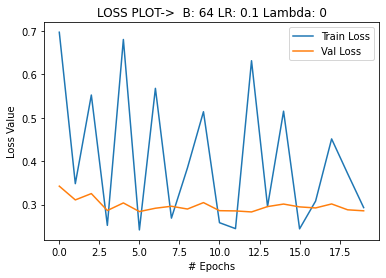

BATCH SIZE =  128 	LR =  0.001 	LAMBDA =  0

Epoch: 1 --> Train Loss = 0.29749430074794797 	--> Val Loss = 0.29820264840496585
Epoch: 2 --> Train Loss = 0.2941940020052701 	--> Val Loss = 0.29621980982454377
Epoch: 3 --> Train Loss = 0.29184617738264773 	--> Val Loss = 0.29469300231999096
Epoch: 4 --> Train Loss = 0.29007411437816405 	--> Val Loss = 0.2934402275619284
Epoch: 5 --> Train Loss = 0.2886675468524829 	--> Val Loss = 0.2923789178638391
Epoch: 6 --> Train Loss = 0.2875039594471157 	--> Val Loss = 0.29146219534890144
Epoch: 7 --> Train Loss = 0.2865084192497923 	--> Val Loss = 0.29065953542922507
Epoch: 8 --> Train Loss = 0.28563314300548137 	--> Val Loss = 0.2899493252943347
Epoch: 9 --> Train Loss = 0.2848465850308889 	--> Val Loss = 0.2893154368945897
Epoch: 10 --> Train Loss = 0.28412730622317095 	--> Val Loss = 0.28874541308343926
Epoch: 11 --> Train Loss = 0.2834603719441925 	--> Val Loss = 0.28822939968476236
Epoch: 12 --> Train Loss = 0.2828351534929315 	--> Val Loss =

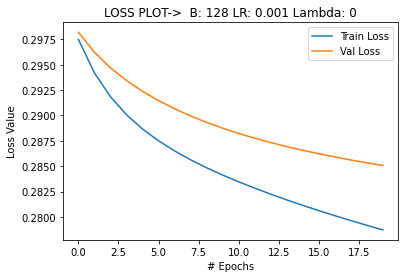

BATCH SIZE =  128 	LR =  0.01 	LAMBDA =  0

Epoch: 1 --> Train Loss = 0.3079515882942304 	--> Val Loss = 0.28943374131106003
Epoch: 2 --> Train Loss = 0.28431985736556514 	--> Val Loss = 0.283455649914555
Epoch: 3 --> Train Loss = 0.2905125670600195 	--> Val Loss = 0.2823901084258926
Epoch: 4 --> Train Loss = 0.2694148686117777 	--> Val Loss = 0.28058774655695046
Epoch: 5 --> Train Loss = 0.2749383405025524 	--> Val Loss = 0.279507655093624
Epoch: 6 --> Train Loss = 0.26955998120455993 	--> Val Loss = 0.27904938995160977
Epoch: 7 --> Train Loss = 0.26563630052422116 	--> Val Loss = 0.27767139406448643
Epoch: 8 --> Train Loss = 0.26447729294927214 	--> Val Loss = 0.2779520727557763
Epoch: 9 --> Train Loss = 0.26373551718863003 	--> Val Loss = 0.2765711287038587
Epoch: 10 --> Train Loss = 0.2592579740609158 	--> Val Loss = 0.2770528126054924
Epoch: 11 --> Train Loss = 0.2614454512350252 	--> Val Loss = 0.27585410469289384
Epoch: 12 --> Train Loss = 0.25651907000848595 	--> Val Loss = 0.2

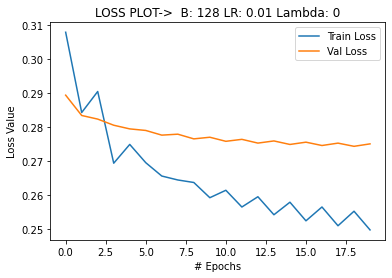

BATCH SIZE =  128 	LR =  0.1 	LAMBDA =  0

Epoch: 1 --> Train Loss = 0.2752908935872525 	--> Val Loss = 0.4831872468357229
Epoch: 2 --> Train Loss = 0.5852956337782739 	--> Val Loss = 0.41814850494782646
Epoch: 3 --> Train Loss = 0.3419308997580524 	--> Val Loss = 0.4355792134819512
Epoch: 4 --> Train Loss = 0.23759107552809366 	--> Val Loss = 0.4025363436345005
Epoch: 5 --> Train Loss = 0.22770178510610486 	--> Val Loss = 0.44398213538949693
Epoch: 6 --> Train Loss = 0.47987412321589656 	--> Val Loss = 0.3922997872131379
Epoch: 7 --> Train Loss = 0.6956405985689291 	--> Val Loss = 0.3597253957774834
Epoch: 8 --> Train Loss = 0.19237294111178332 	--> Val Loss = 0.32499813380518
Epoch: 9 --> Train Loss = 0.17540118137200625 	--> Val Loss = 0.3161794720767487
Epoch: 10 --> Train Loss = 0.2706716199640554 	--> Val Loss = 0.3346929573703693
Epoch: 11 --> Train Loss = 0.827266291769436 	--> Val Loss = 0.3561367181705019
Epoch: 12 --> Train Loss = 0.19458538589448038 	--> Val Loss = 0.364818

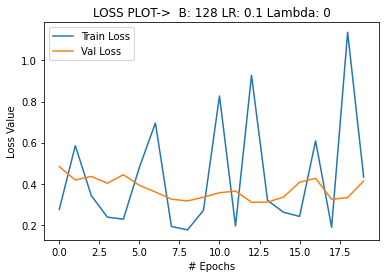

BATCH SIZE =  32 	LR =  0.001 	LAMBDA =  0.01


TRAIN ACCURACY =  58.59375 %
VAL ACCURACY =  58.12500000000001 %
TEST ACCURACY =  55.00000000000001 %


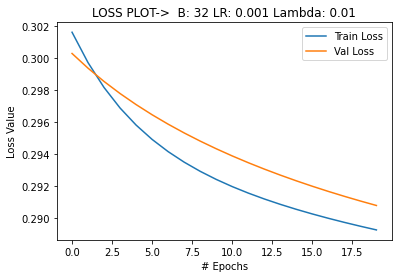

BATCH SIZE =  32 	LR =  0.01 	LAMBDA =  0.01


TRAIN ACCURACY =  60.0 %
VAL ACCURACY =  59.375 %
TEST ACCURACY =  58.5 %


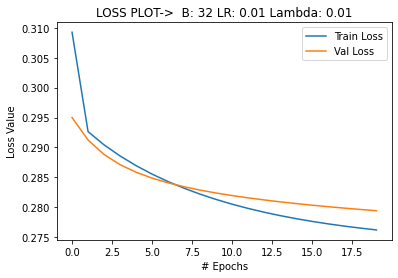

BATCH SIZE =  32 	LR =  0.1 	LAMBDA =  0.01


TRAIN ACCURACY =  59.06249999999999 %
VAL ACCURACY =  59.375 %
TEST ACCURACY =  61.0 %


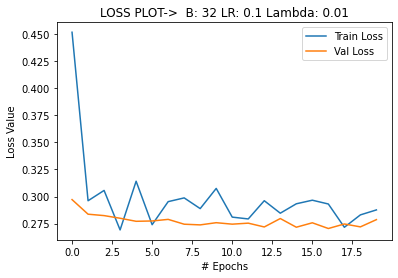

BATCH SIZE =  64 	LR =  0.001 	LAMBDA =  0.01


TRAIN ACCURACY =  58.12500000000001 %
VAL ACCURACY =  57.49999999999999 %
TEST ACCURACY =  55.50000000000001 %


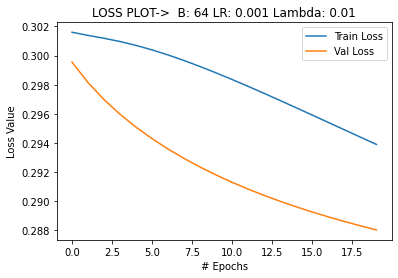

BATCH SIZE =  64 	LR =  0.01 	LAMBDA =  0.01


TRAIN ACCURACY =  61.25000000000001 %
VAL ACCURACY =  61.25000000000001 %
TEST ACCURACY =  57.49999999999999 %


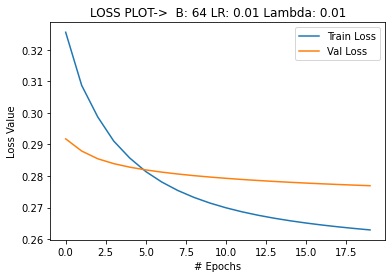

BATCH SIZE =  64 	LR =  0.1 	LAMBDA =  0.01


TRAIN ACCURACY =  54.84375 %
VAL ACCURACY =  53.75 %
TEST ACCURACY =  59.5 %


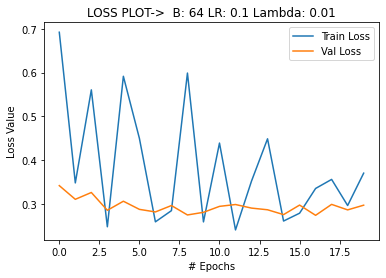

BATCH SIZE =  128 	LR =  0.001 	LAMBDA =  0.01


TRAIN ACCURACY =  58.59375 %
VAL ACCURACY =  58.12500000000001 %
TEST ACCURACY =  55.50000000000001 %


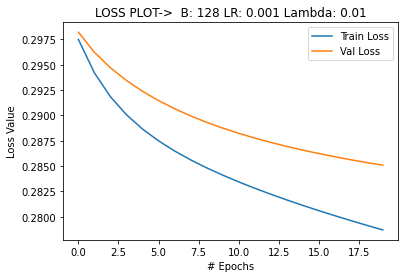

BATCH SIZE =  128 	LR =  0.01 	LAMBDA =  0.01


TRAIN ACCURACY =  60.78125 %
VAL ACCURACY =  61.25000000000001 %
TEST ACCURACY =  60.0 %


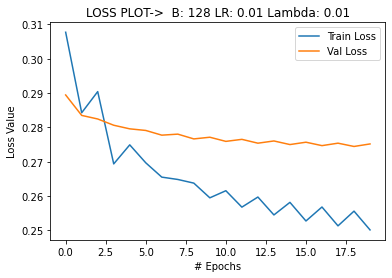

BATCH SIZE =  128 	LR =  0.1 	LAMBDA =  0.01


TRAIN ACCURACY =  54.6875 %
VAL ACCURACY =  52.5 %
TEST ACCURACY =  62.5 %


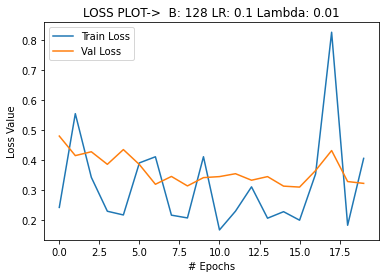

BATCH SIZE =  32 	LR =  0.001 	LAMBDA =  0.1


TRAIN ACCURACY =  58.59375 %
VAL ACCURACY =  58.12500000000001 %
TEST ACCURACY =  55.00000000000001 %


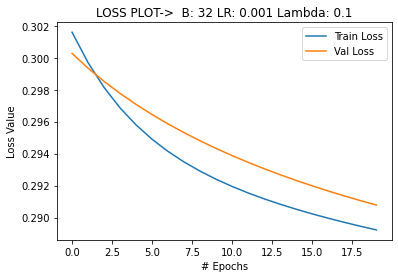

BATCH SIZE =  32 	LR =  0.01 	LAMBDA =  0.1


TRAIN ACCURACY =  59.84374999999999 %
VAL ACCURACY =  60.0 %
TEST ACCURACY =  58.5 %


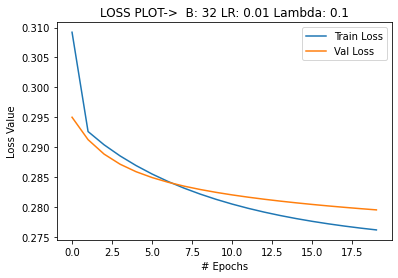

BATCH SIZE =  32 	LR =  0.1 	LAMBDA =  0.1


TRAIN ACCURACY =  57.96875 %
VAL ACCURACY =  58.75 %
TEST ACCURACY =  61.5 %


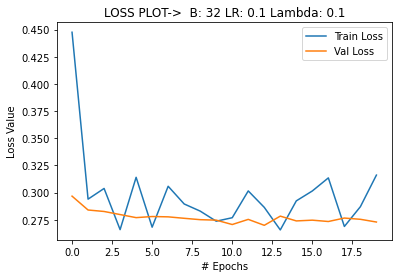

BATCH SIZE =  64 	LR =  0.001 	LAMBDA =  0.1


TRAIN ACCURACY =  58.12500000000001 %
VAL ACCURACY =  57.49999999999999 %
TEST ACCURACY =  55.50000000000001 %


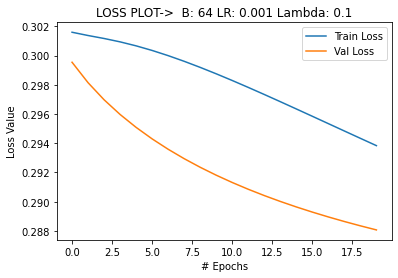

BATCH SIZE =  64 	LR =  0.01 	LAMBDA =  0.1


TRAIN ACCURACY =  61.09375 %
VAL ACCURACY =  60.62499999999999 %
TEST ACCURACY =  57.49999999999999 %


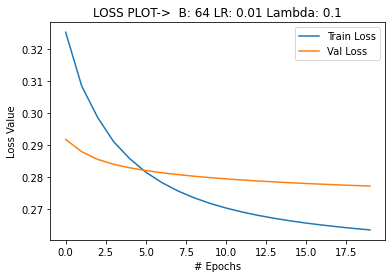

BATCH SIZE =  64 	LR =  0.1 	LAMBDA =  0.1


TRAIN ACCURACY =  55.46875 %
VAL ACCURACY =  52.5 %
TEST ACCURACY =  59.5 %


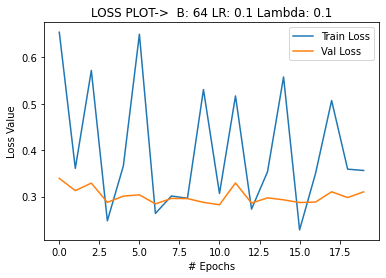

BATCH SIZE =  128 	LR =  0.001 	LAMBDA =  0.1


TRAIN ACCURACY =  58.59375 %
VAL ACCURACY =  58.12500000000001 %
TEST ACCURACY =  56.00000000000001 %


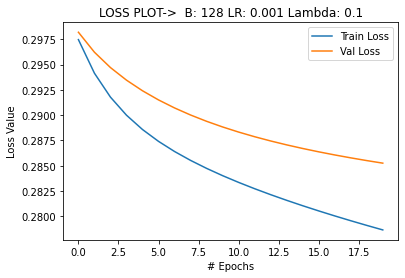

BATCH SIZE =  128 	LR =  0.01 	LAMBDA =  0.1


TRAIN ACCURACY =  60.3125 %
VAL ACCURACY =  61.875 %
TEST ACCURACY =  60.0 %


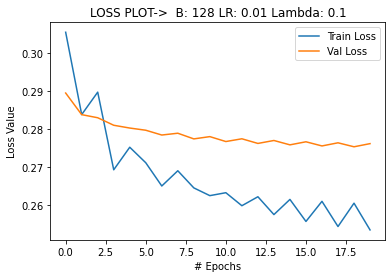

BATCH SIZE =  128 	LR =  0.1 	LAMBDA =  0.1


TRAIN ACCURACY =  51.5625 %
VAL ACCURACY =  49.375 %
TEST ACCURACY =  59.5 %


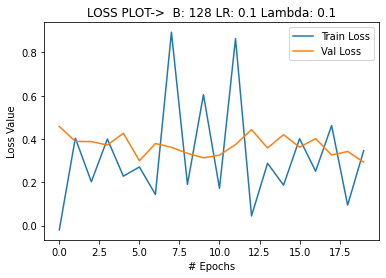

BATCH SIZE =  32 	LR =  0.001 	LAMBDA =  1


TRAIN ACCURACY =  58.59375 %
VAL ACCURACY =  58.12500000000001 %
TEST ACCURACY =  55.00000000000001 %


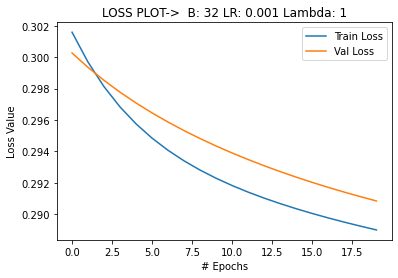

BATCH SIZE =  32 	LR =  0.01 	LAMBDA =  1


TRAIN ACCURACY =  59.06249999999999 %
VAL ACCURACY =  60.0 %
TEST ACCURACY =  58.5 %


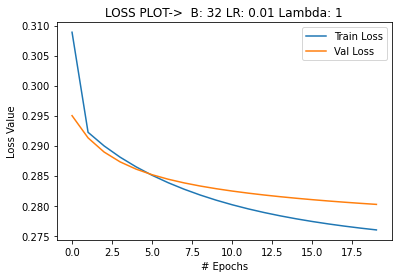

BATCH SIZE =  32 	LR =  0.1 	LAMBDA =  1


TRAIN ACCURACY =  59.06249999999999 %
VAL ACCURACY =  58.75 %
TEST ACCURACY =  60.5 %


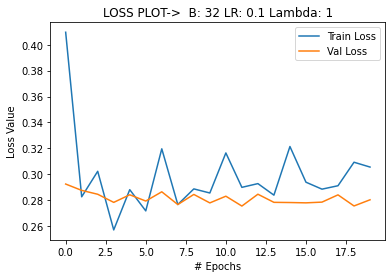

BATCH SIZE =  64 	LR =  0.001 	LAMBDA =  1


TRAIN ACCURACY =  58.12500000000001 %
VAL ACCURACY =  57.49999999999999 %
TEST ACCURACY =  55.50000000000001 %


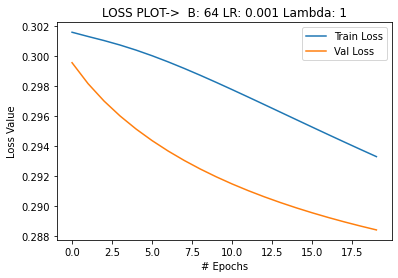

BATCH SIZE =  64 	LR =  0.01 	LAMBDA =  1


TRAIN ACCURACY =  59.375 %
VAL ACCURACY =  60.0 %
TEST ACCURACY =  57.99999999999999 %


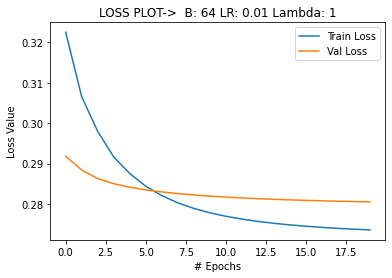

BATCH SIZE =  64 	LR =  0.1 	LAMBDA =  1


TRAIN ACCURACY =  51.24999999999999 %
VAL ACCURACY =  51.24999999999999 %
TEST ACCURACY =  60.0 %


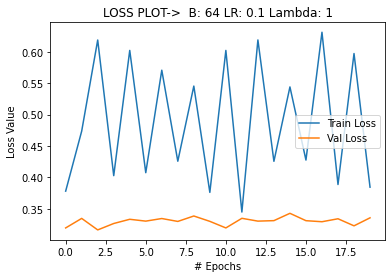

BATCH SIZE =  128 	LR =  0.001 	LAMBDA =  1


TRAIN ACCURACY =  58.28124999999999 %
VAL ACCURACY =  58.12500000000001 %
TEST ACCURACY =  55.50000000000001 %


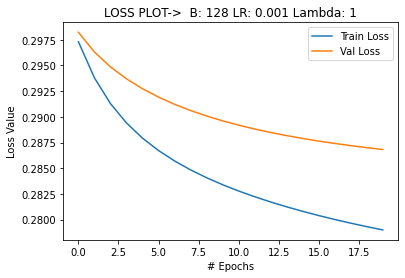

BATCH SIZE =  128 	LR =  0.01 	LAMBDA =  1


TRAIN ACCURACY =  57.34375000000001 %
VAL ACCURACY =  59.375 %
TEST ACCURACY =  58.5 %


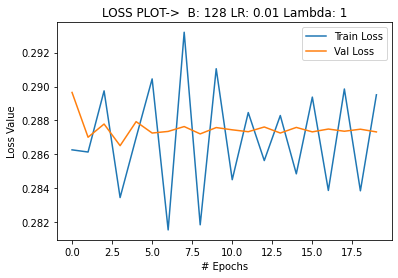

BATCH SIZE =  128 	LR =  0.1 	LAMBDA =  1


TRAIN ACCURACY =  47.96875 %
VAL ACCURACY =  49.375 %
TEST ACCURACY =  53.0 %


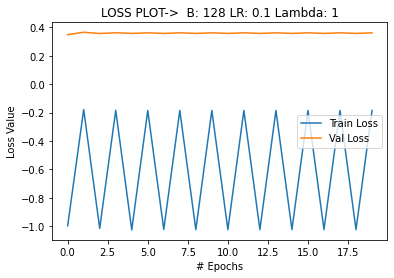

In [128]:
batch_size = [32,64,128]
lr = [0.001,0.01,0.1]
lmbda = [0,1e-2,1e-1,1]

for lm in lmbda:
    for b in batch_size:
        for l in lr:
            print('\033[1m' + 'BATCH SIZE = ',b,'\tLR = ',l,'\tLAMBDA = ',lm)
            print ('\033[0m')
            df = main(b,l,lm,df)

In [129]:
#### LOSS DATAFRAME FOR ALL THE CASES

df

,Lambda,Batch Size,Learning Rate,Test Accuracy
0,0.00,32.0,0.001,55.0
1,0.00,32.0,0.010,58.5
2,0.00,32.0,0.100,59.0
3,0.00,64.0,0.001,55.5
4,0.00,64.0,0.010,57.5
5,0.00,64.0,0.100,59.5
6,0.00,128.0,0.001,55.5
7,0.00,128.0,0.010,60.5
8,0.00,128.0,0.100,56.5
9,0.01,32.0,0.001,55.0


Model is underfitting if:

    - Loss remains flat regardless of training
    - Loss continues to decrease at high rate until the end of training (this can be neglected in few cases due to low
      number of epochs
    - Large values of loss or noisy curves

The following cases show this behaviour:

| Batch Size | LR | Lambda |
| :-: | :-: | :-: |
| 64 | 0.1 | 0 |
| 128 | 0.1 | 0 |
| 64 | 0.1 | 0.01 |
| 128 | 0.1 | 0.01 |
| 64 | 0.1 | 0.1 |
| 128 | 0.1 | 0.1 |
| 64 | 0.1 | 1 |
| 128 | 0.1 | 1 |

#### Some of these cases show very high accuracy on test set. This can be attributed to the data. Looking at the loss plots, the underfitting nature is palpable.

Epoch: 1 --> Train Loss = 0.6965754845190658 	--> Val Loss = 0.34245176475422995
Epoch: 2 --> Train Loss = 0.3481744668329924 	--> Val Loss = 0.3108271316673573
Epoch: 3 --> Train Loss = 0.5521357106081968 	--> Val Loss = 0.325357128811777
Epoch: 4 --> Train Loss = 0.25229543361562967 	--> Val Loss = 0.28641743286166965
Epoch: 5 --> Train Loss = 0.679917219794307 	--> Val Loss = 0.3038812907873442
Epoch: 6 --> Train Loss = 0.24179121019632044 	--> Val Loss = 0.2840076665251501
Epoch: 7 --> Train Loss = 0.5675131559587994 	--> Val Loss = 0.29168240732715356
Epoch: 8 --> Train Loss = 0.2689259048862628 	--> Val Loss = 0.29625126284229897
Epoch: 9 --> Train Loss = 0.3844353703741861 	--> Val Loss = 0.2898470333617181
Epoch: 10 --> Train Loss = 0.5136829649097026 	--> Val Loss = 0.30462152250668373
Epoch: 11 --> Train Loss = 0.25840885048169426 	--> Val Loss = 0.2860378025387887
Epoch: 12 --> Train Loss = 0.24475638910853076 	--> Val Loss = 0.28549918868034885
Epoch: 13 --> Train Loss = 0.

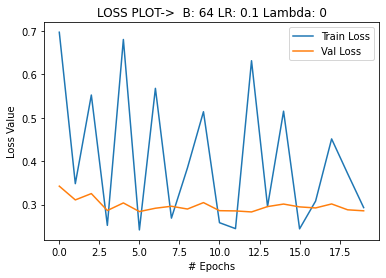

Epoch: 1 --> Train Loss = 0.2752908935872525 	--> Val Loss = 0.4831872468357229
Epoch: 2 --> Train Loss = 0.5852956337782739 	--> Val Loss = 0.41814850494782646
Epoch: 3 --> Train Loss = 0.3419308997580524 	--> Val Loss = 0.4355792134819512
Epoch: 4 --> Train Loss = 0.23759107552809366 	--> Val Loss = 0.4025363436345005
Epoch: 5 --> Train Loss = 0.22770178510610486 	--> Val Loss = 0.44398213538949693
Epoch: 6 --> Train Loss = 0.47987412321589656 	--> Val Loss = 0.3922997872131379
Epoch: 7 --> Train Loss = 0.6956405985689291 	--> Val Loss = 0.3597253957774834
Epoch: 8 --> Train Loss = 0.19237294111178332 	--> Val Loss = 0.32499813380518
Epoch: 9 --> Train Loss = 0.17540118137200625 	--> Val Loss = 0.3161794720767487
Epoch: 10 --> Train Loss = 0.2706716199640554 	--> Val Loss = 0.3346929573703693
Epoch: 11 --> Train Loss = 0.827266291769436 	--> Val Loss = 0.3561367181705019
Epoch: 12 --> Train Loss = 0.19458538589448038 	--> Val Loss = 0.3648185169248988
Epoch: 13 --> Train Loss = 0.927

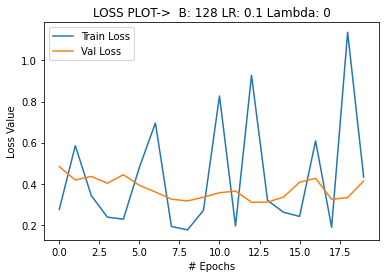


TRAIN ACCURACY =  54.84375 %
VAL ACCURACY =  53.75 %
TEST ACCURACY =  59.5 %


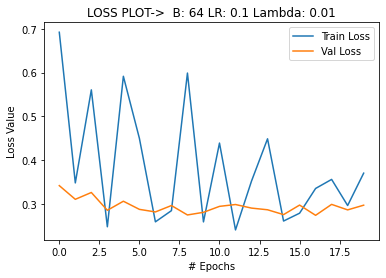


TRAIN ACCURACY =  54.6875 %
VAL ACCURACY =  52.5 %
TEST ACCURACY =  62.5 %


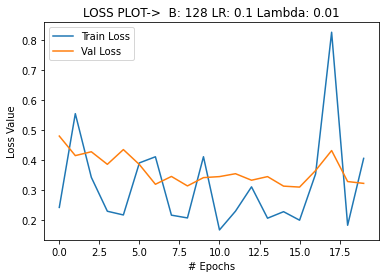


TRAIN ACCURACY =  55.46875 %
VAL ACCURACY =  52.5 %
TEST ACCURACY =  59.5 %


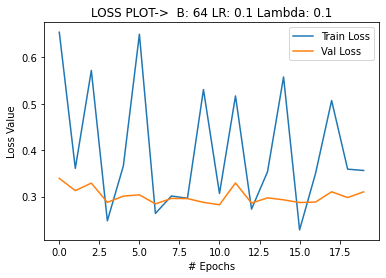


TRAIN ACCURACY =  51.5625 %
VAL ACCURACY =  49.375 %
TEST ACCURACY =  59.5 %


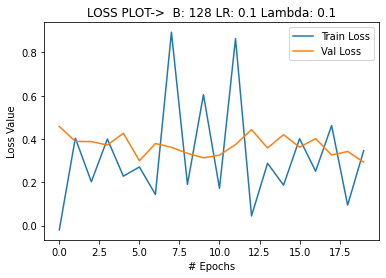


TRAIN ACCURACY =  51.24999999999999 %
VAL ACCURACY =  51.24999999999999 %
TEST ACCURACY =  60.0 %


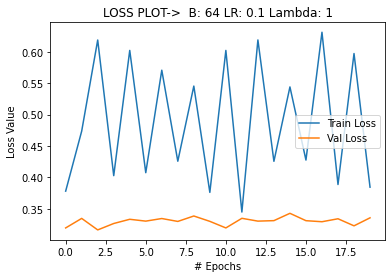


TRAIN ACCURACY =  47.96875 %
VAL ACCURACY =  49.375 %
TEST ACCURACY =  53.0 %


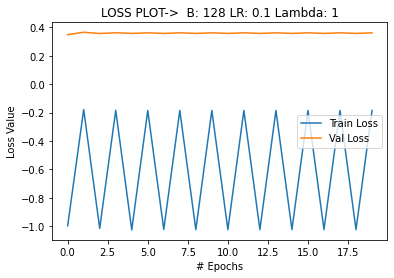

In [132]:
### SHOWING UNDER-FITTED PLOTS


df = pd.DataFrame(columns = ['Lambda', 'Batch Size', 'Learning Rate', 'Test Accuracy']) ## Stores the accuracy on test set

df = main(64,0.1,0,df)
df = main(128,0.1,0,df)
df = main(64,0.1,0.01,df)
df = main(128,0.1,0.01,df)
df = main(64,0.1,0.1,df)
df = main(128,0.1,0.1,df)
df = main(64,0.1,1,df)
df = main(128,0.1,1,df)

In [133]:
#### LOSS DATAFRAME FOR THE UNDERFITTED CASES

df

,Lambda,Batch Size,Learning Rate,Test Accuracy
0,0.00,64.0,0.1,59.5
1,0.00,128.0,0.1,56.5
2,0.01,64.0,0.1,59.5
3,0.01,128.0,0.1,62.5
4,0.10,64.0,0.1,59.5
5,0.10,128.0,0.1,59.5
6,1.00,64.0,0.1,60.0
7,1.00,128.0,0.1,53.0


Model is overfitting if:

    - The plot of validation loss decreases to a point and begins increasing again
    
None of the cases show this sort of behaviour. This can be attributed to the fact that number of epochs are very small and so the point of over-fitting isn't reached.